In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from tqdm.notebook import tqdm
from glob import glob

# Audio
import librosa
import librosa.display as dsp
import IPython.display as ipd
import seaborn as sns

In [6]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(813)

# Read csv file
train_csv = pd.read_csv('./data/train.csv')
test_csv = pd.read_csv('./data/test.csv')
submission_csv = pd.read_csv('./data/sample_submission.csv')

train_csv

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


In [4]:
# Read audio dataset 
# Data path
train_path_list = glob('./data/train/*.*')
test_path_list = glob('./data/test/*.*')

print('train data count: ', len(train_path_list))
print('train data count: ', len(test_path_list))

train data count:  1279
train data count:  1514


  0%|          | 0/1514 [00:00<?, ?it/s]

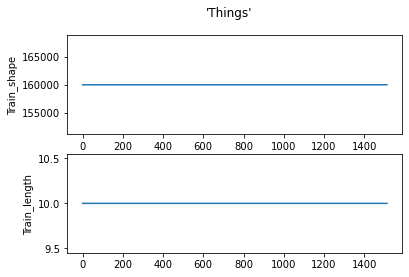

In [5]:
def plot_things(path, sr):
  plot_length = []
  plot_shape = []

  for i in tqdm(path):
    data, sample_rate = librosa.load(i, sr=sr)
    plot_shape.append(data.shape)
    plot_length.append(data.shape[0]/float(sample_rate))

  plt.subplot(211)
  plt.plot(plot_shape)
  plt.ylabel('Train_shape')

  plt.subplot(212)
  plt.plot(plot_length)
  plt.ylabel('Train_length')

  plt.suptitle('\'Things\'')
  
  plt.show()

plot_things(test_path_list, sr)

In [7]:
sr = 16000

# train_file_names = train_csv["file_name"].to_numpy()
# test_file_names = test_csv["file_name"].to_numpy()
target = train_csv["LABEL"].to_numpy()

def load_audio(file_names, target):   
  data = []
  for audio in tqdm(file_names):
    # librosa를 이용하여 데이터 로드
    an_audio, _ = librosa.load(audio, sr=sr)
    audio_array = np.array(an_audio)
    data.append(audio_array)
  data = np.array(data)

  label = target.copy()

  return data, label

train_audio_data, train_label = load_audio(train_path_list, target)
test_audio_data, _ = load_audio(test_path_list, np.array([None]))

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

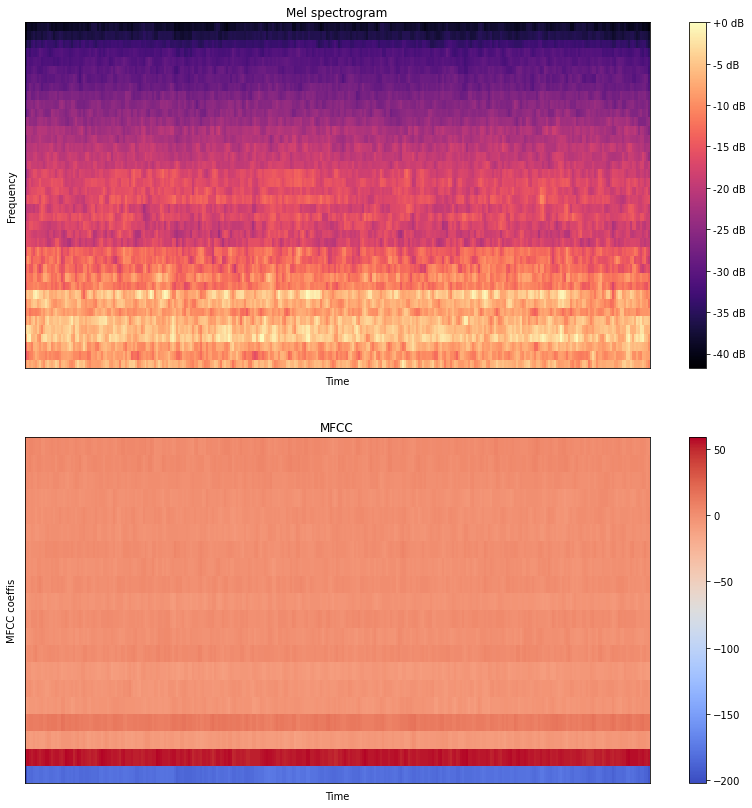

In [21]:
plt.figure(figsize=(14,14))
ax = plt.subplot(2, 1, 1)

ax = plt.subplot(2, 1, 1)
S = librosa.feature.melspectrogram(y=train_audio_data[15], sr=sr, n_mels=40)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr)
plt.title('Mel spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

ax = plt.subplot(2, 1, 2)
mfcc = librosa.feature.mfcc(y=train_audio_data[15], sr=sr, n_mels=40)
librosa.display.specshow(mfcc, sr=sr)
plt.title('MFCC')
plt.xlabel("Time")
plt.ylabel("MFCC coeffis")
plt.colorbar()

In [30]:
# train_audio_data
# test_audio_data

def audio2feature(audio_data):
  size = 40
  audio_mels = []
  audio_mfcc = []

  for signal in tqdm(audio_data):
    # mels
    mels = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=size)
    mels = librosa.power_to_db(mels, ref=np.max)
    # mfcc
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=size)

    audio_mels.append(mels)
    audio_mfcc.append(mfcc)

  return audio_mels, audio_mfcc

train_audio_mels, train_audio_mfcc = audio2feature(train_audio_data)
test_audio_mels, test_audio_mfcc = audio2feature(test_audio_data)

# Audio needs to be converted to numpy array
audio_mels_array = np.array(train_audio_mels, np.float64)
audio_mfcc_array = np.array(train_audio_mfcc, np.float64)

audio_mels_array_test = np.array(test_audio_mels, np.float64)
audio_mfcc_array_test = np.array(test_audio_mfcc, np.float64)

print('Train audio feature')
print('mels size: ', np.shape(train_audio_mels))
print('mfcc size: ', np.shape(train_audio_mfcc))
print('-'*20)
print('Test audio feature')
print('mels size: ', np.shape(test_audio_mels))
print('mfcc size: ', np.shape(test_audio_mfcc))

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

Train audio feature
mels size:  (1279, 40, 313)
mfcc size:  (1279, 40, 313)
--------------------
Test audio feature
mels size:  (1514, 40, 313)
mfcc size:  (1514, 40, 313)


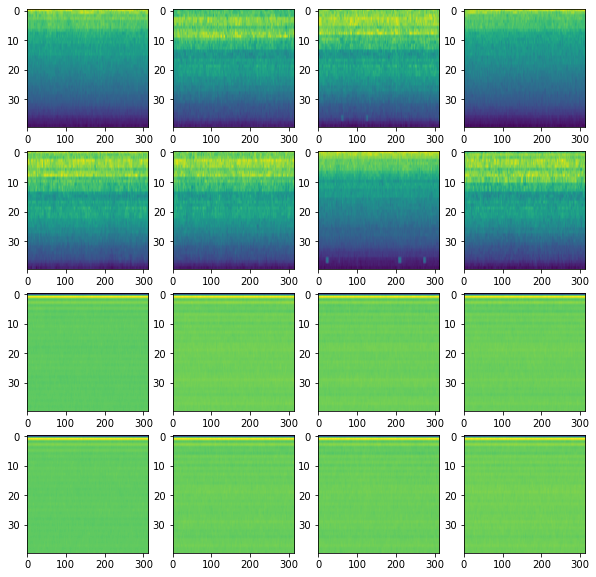

In [34]:
# Check this shizz out
target_num = 0
target_num_idx = np.where(train_label==target_num)[0]
target_num_idx = np.random.choice(target_num_idx,16)

plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)

for i, idx in enumerate(target_num_idx):
  ax = plt.subplot(4, 4, i + 1)
  if i<8:
    plt.imshow(audio_mels_array[idx], aspect='auto')
  else:
    plt.imshow(audio_mfcc_array[idx], aspect='auto')

In [37]:
set(train_csv["LABEL"])

{0}

In [29]:
audio_mels_array = np.array(train_audio_mels, np.float64)
audio_mfcc_array = np.array(train_audio_mfcc, np.float64)

audio_mels_array_test = np.array(test_audio_mels, np.float64)
audio_mfcc_array_test = np.array(test_audio_mfcc, np.float64)